In this notebook, we will predict which individuals make more than $50K from Census data. This is the same dataset used in the AutoGluon tabular prediction example.


In [1]:
!git clone https://github.com/nageshsinghc4/deepwrap.git
!cd deepwrap/
import os
os.chdir('/content/deepwrap/')
os.getcwd()
!pip install .

Cloning into 'deepwrap'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 277 (delta 39), reused 256 (delta 27), pack-reused 0
Receiving objects: 100% (277/277), 25.31 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Processing /content/deepwrap
     |████████████████████████████████| 25.9MB 101kB/s 
     |████████████████████████████████| 983kB 49.8MB/s 
     |████████████████████████████████| 245kB 47.2MB/s 
     |████████████████████████████████| 1.1MB 34.1MB/s 
     |████████████████████████████████| 471kB 50.9MB/s 
     |████████████████████████████████| 1.1MB 43.6MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
     |████████████████████████████████| 3.0MB 45.6MB/s 
  Created wheel for DEEPWRAP: filename=DEEPWRAP-50.3.0-cp36-none-any.whl size=159940 sha256=ec2762e6e50a6c7f196d398369add89e6df8f82ba1e43eede91c03c9db3ab6ab
  Stored in directory: /tmp/p

In [2]:
%matplotlib inline
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

import urllib.request
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

import deepwrap
from deepwrap import tabledata

Collect Training and Test Sets

In [3]:
# training set
# download dataset
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv',
                           '/content/deepwrap/examples/income/train.csv')

('/content/deepwrap/examples/income/train.csv',
 <http.client.HTTPMessage at 0x7fafe8e44ba8>)

STEP 1: Load and Preprocess Data

In [4]:
trn, val, preproc = tabledata.load_from_csv('/content/deepwrap/examples/income/train.csv',
                                            label_columns='class', random_state=42)

processing train: 35179 rows x 15 columns

The following integer column(s) are being treated as categorical variables:
['education-num']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 3894 rows x 15 columns


In [5]:
print(trn)

STEP 2: Create Model and Wrap in Learner

In [7]:
# Invoking multilayer perceptron
model = tabledata.tabular_classifier('mlp', trn)
learner = deepwrap.get_learner(model, train_data=trn, val_data=val, batch_size=128)

Is Multi-Label? False
done.


STEP 3: Estimate Learning Rate


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
274/274 [==============================] - 5s 19ms/step - loss: 0.6618 - accuracy: 0.7619
Epoch 2/1024
274/274 [==============================] - 5s 18ms/step - loss: 0.5963 - accuracy: 0.7678
Epoch 3/1024
274/274 [==============================] - 5s 19ms/step - loss: 0.3959 - accuracy: 0.8199
Epoch 4/1024
274/274 [==============================] - 5s 18ms/step - loss: 0.3244 - accuracy: 0.8496
Epoch 5/1024
274/274 [==============================] - 5s 19ms/step - loss: 2.1016 - accuracy: 0.8109


done.
Visually inspect loss plot and select learning rate associated with falling loss
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
275/275 [==============================] - 7s 26ms/step - loss: 0.3596 - accuracy: 0.8353 - val_loss: 0.2960 - val_a

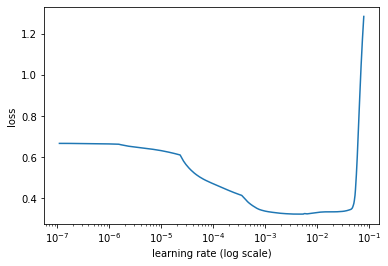

In [8]:
learner.lr_find(show_plot=True)


#STEP 4: Train
learner.autofit(1e-3)

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      3013
        >50K       0.74      0.61      0.67       881

    accuracy                           0.86      3894
   macro avg       0.82      0.78      0.79      3894
weighted avg       0.86      0.86      0.86      3894



array([[2823,  190],
       [ 340,  541]])

Evaluate Model on Unseen Test Data


In [11]:
# download test dataset
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv', 
                           '/content/deepwrap/examples/income/test.csv')

test_df = pd.read_csv('/content/deepwrap/examples/income/test.csv')
print(test_df)


      age          workclass  fnlwgt      education  education-num  \
0      31            Private  169085           11th              7   
1      17   Self-emp-not-inc  226203           12th              8   
2      47            Private   54260      Assoc-voc             11   
3      21            Private  176262   Some-college             10   
4      17            Private  241185           12th              8   
...   ...                ...     ...            ...            ...   
9764   36            Private  191146   Some-college             10   
9765   34            Private  422836        HS-grad              9   
9766   44            Private   75012        HS-grad              9   
9767   18            Private  194561   Some-college             10   
9768   42        Federal-gov   53727        HS-grad              9   

           marital-status         occupation relationship    race      sex  \
0      Married-civ-spouse              Sales         Wife   White   Female   
1  

In [12]:
learner.evaluate(preproc.preprocess_test(test_df), class_names=preproc.get_classes())

#Generating Test Results
#Let's generate a DataFrame showing the test set predictions for each instance:
preproc.get_classes()

processing test: 9769 rows x 15 columns
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7451
        >50K       0.76      0.61      0.67      2318

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



['<=50K', '>50K']

Predictions

In [13]:
predictor = deepwrap.get_predictor(learner.model, preproc)
preds = predictor.predict(test_df)

df = test_df.copy()
df['predicted_class'] = preds

print(df)

      age          workclass  fnlwgt      education  education-num  \
0      31            Private  169085           11th              7   
1      17   Self-emp-not-inc  226203           12th              8   
2      47            Private   54260      Assoc-voc             11   
3      21            Private  176262   Some-college             10   
4      17            Private  241185           12th              8   
...   ...                ...     ...            ...            ...   
9764   36            Private  191146   Some-college             10   
9765   34            Private  422836        HS-grad              9   
9766   44            Private   75012        HS-grad              9   
9767   18            Private  194561   Some-college             10   
9768   42        Federal-gov   53727        HS-grad              9   

           marital-status         occupation relationship    race      sex  \
0      Married-civ-spouse              Sales         Wife   White   Female   
1  